In [1]:
%matplotlib inline

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed

from sklearn.preprocessing import MinMaxScaler

from csef.model import lstm
from csef.data import preprocessing, load_data
from csef.utils import performance
from csef.model.base import GeneralModel

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [2]:
data_mapping = load_data.load_data()
consumption_train = data_mapping['consumption_train']
cold_start_test = data_mapping['cold_start_test']
submission_format = data_mapping['submission_format']
meta = data_mapping['meta']

In [3]:
samp_df = load_data.sampling_data(consumption_train)

In [4]:
load_data.describe_training_data(samp_df)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


## Training

In [5]:
train_df, test_df = load_data.train_test_split(samp_df)

/home/thuongdinh/ws/asnet-training/ml-training/ml-energy-forecasting/csef/data/load_data.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  split_train[group_col] = ser_id
/home/thuongdinh/ws/asnet-training/ml-training/ml-energy-forecasting/csef/data/load_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  split_test[group_col] = ser_id


In [6]:
load_data.describe_training_data(train_df)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


In [7]:
# Default config
n_batch = 1
n_input = 24
n_nodes = 24

batch_input_shape = (n_batch, 1, n_input)

## Two level stacking

In [8]:
config = {
    'n_input': n_input,
    'n_nodes': n_nodes,
    'n_batch': n_batch,
    'model': [
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'batch_input_shape': batch_input_shape,
                'stateful': True,
                'activation': 'relu',
                'return_sequences': True
            }
        },
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'activation': 'relu',
                'stateful': True
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 1
            }
        }
    ]
}

In [9]:
scores = performance.repeat_evaluate(GeneralModel, train_df, test_df, config, n_repeats=20)

Fitting the data: 100%|██████████| 10/10 [00:27<00:00,  2.61s/it]


 > 26481.887


Fitting the data: 100%|██████████| 10/10 [00:27<00:00,  2.64s/it]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

lstm: 0.291 RMSE (+/- 0.005)


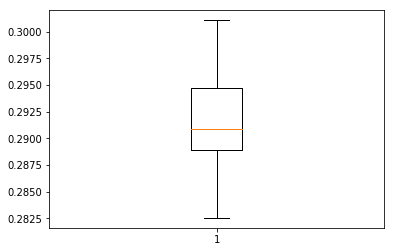

In [10]:
performance.summarize_scores('lstm', scores)